In [1]:
import pandas as pd # Reads and manipulates tabular data (CSV → DataFrame)
from wordcloud import WordCloud # Provides the WordCloud class to create word-cloud visualizations of frequent words
import matplotlib.pyplot as plt # used to draw the bar chart of class counts.
import nltk # NLTK gives you NLP utilities and corpora (stopwords, tokenizers, etc.)
from nltk.corpus import stopwords #you download and use the English stopword list to remove common words like "the", "and", etc.
import warnings
warnings.filterwarnings("ignore")
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
griv = pd.read_csv(r"C:\Users\sande\Downloads\greviance.csv")

In [3]:
griv.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-10-27,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,33181,NaN,NaN,Web,2023-10-27,In progress,Yes,NaN,7766284
1,2023-10-23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,Self Financial Inc.,CA,92109,NaN,NaN,Web,2023-11-07,Closed with explanation,Yes,NaN,7745570
2,2023-05-04,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was already discharged in bankruptcy and ...,My personal identifying information was used t...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28269,NaN,Consent provided,Web,2023-06-13,Closed with non-monetary relief,Yes,NaN,6928521
3,2023-11-09,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,NaN,"EQUIFAX, INC.",SC,29486,NaN,NaN,Web,2023-11-09,In progress,Yes,NaN,7825790
4,2023-10-26,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,CA,92880,NaN,NaN,Web,2023-10-26,In progress,Yes,NaN,7756715


In [4]:
griv.shape

(4280531, 18)

In [5]:
griv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280531 entries, 0 to 4280530
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 587.

In [6]:
griv.describe()

,Complaint ID
count,4.280531e+06
mean,4.490320e+06
std,2.106724e+06
min,1.000000e+00
25%,2.944422e+06
50%,4.466883e+06
75%,6.378116e+06
max,7.836575e+06


In [7]:
griv = griv.loc[:, ['Product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']]
# Selects only these four columns from the original DataFrame and returns all rows but only those columns.

In [8]:
griv.head(2)

,Product,Issue,Sub-issue,Consumer complaint narrative
0,Credit reporting or other personal consumer re...,Incorrect information on your report,Information belongs to someone else,NaN
1,Credit reporting or other personal consumer re...,Incorrect information on your report,Account information incorrect,NaN


In [9]:
griv.columns

Index(['Product', 'Issue', 'Sub-issue', 'Consumer complaint narrative'], dtype='object')

In [10]:
griv.shape

(4280531, 4)

In [11]:
griv['Product'].unique()

array(['Credit reporting or other personal consumer reports',
       'Debt collection', 'Checking or savings account', 'Student loan',
       'Mortgage',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card', 'Vehicle loan or lease',
       'Payday loan, title loan, personal loan, or advance loan',
       'Payday loan, title loan, or personal loan',
       'Money transfer, virtual currency, or money service',
       'Prepaid card', 'Credit card or prepaid card', 'Consumer Loan',
       'Debt or credit management', 'Payday loan',
       'Bank account or service', 'Credit reporting',
       'Other financial service', 'Money transfers', 'Virtual currency'],
      dtype=object)

In [12]:
griv['Product'].nunique()

21

In [13]:
griv['Product'].value_counts()

Product
Credit reporting, credit repair services, or other personal consumer reports    2164406
Debt collection                                                                  515523
Mortgage                                                                         386873
Credit reporting or other personal consumer reports                              220637
Credit card or prepaid card                                                      206365
Checking or savings account                                                      188949
Credit reporting                                                                 140429
Credit card                                                                      100863
Bank account or service                                                           86205
Student loan                                                                      79625
Money transfer, virtual currency, or money service                                60717
Vehicle loan or lease   

In [14]:
griv=griv.sample(frac=1, random_state=555) # Shuffles the DataFrame rows randomly (frac=1 means keep all rows, just shuffle the order).
griv1=griv[0:3100000] # Takes a slice: rows from index 0 up to 4,280,530.

In [15]:
# Converts those three columns to Python str type (ensures no non-string objects like numbers or NaN objects break downstream text processing).

griv1['Issue'] = griv1['Issue'].apply(str) 
griv1['Sub-issue'] = griv1['Sub-issue'].apply(str)
griv1['Consumer complaint narrative'] = griv1['Consumer complaint narrative'].apply(str)

In [16]:
# here we combine all above 3 columns in a single variable i.e 'X' 
# Creates a combined text column 'X' by concatenating Issue, Sub-issue, and Consumer complaint narrative separated by spaces.

griv1['X'] = (griv1['Issue'] + ' ' + 
              griv1['Sub-issue'] + ' ' + 
              griv1['Consumer complaint narrative'])

In [17]:
griv1['X']

74864      Problem with a credit reporting company's inve...
3446425    Incorrect information on your report Informati...
3187517      Account opening, closing, or management nan nan
1512354    Incorrect information on your report Public re...
2183316    Improper use of your report Report provided to...
                                 ...                        
2665570    Managing an account Problem accessing account nan
368747     Unable to get credit report/credit score Probl...
1847623    Improper use of your report Reporting company ...
71753      Problem with a company's investigation into an...
3060231                   Struggling to pay mortgage nan nan
Name: X, Length: 3100000, dtype: object

In [18]:
# Renames column Product to Y, which you treat as the target label variable.

griv1.rename(columns = {'Product' : 'Y'} , inplace = True) 

In [19]:
griv1.head(2)

,Y,Issue,Sub-issue,Consumer complaint narrative,X
74864,"Credit reporting, credit repair services, or o...",Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,"Be it known, According to the FDCPA 15 US Code...",Problem with a credit reporting company's inve...
3446425,"Credit reporting, credit repair services, or o...",Incorrect information on your report,Information belongs to someone else,nan,Incorrect information on your report Informati...


In [20]:
# Keeps only the Y (target) and X (feature text) columns in the DataFrame.

griv1 =griv1.loc[: ,['Y' , 'X']] 

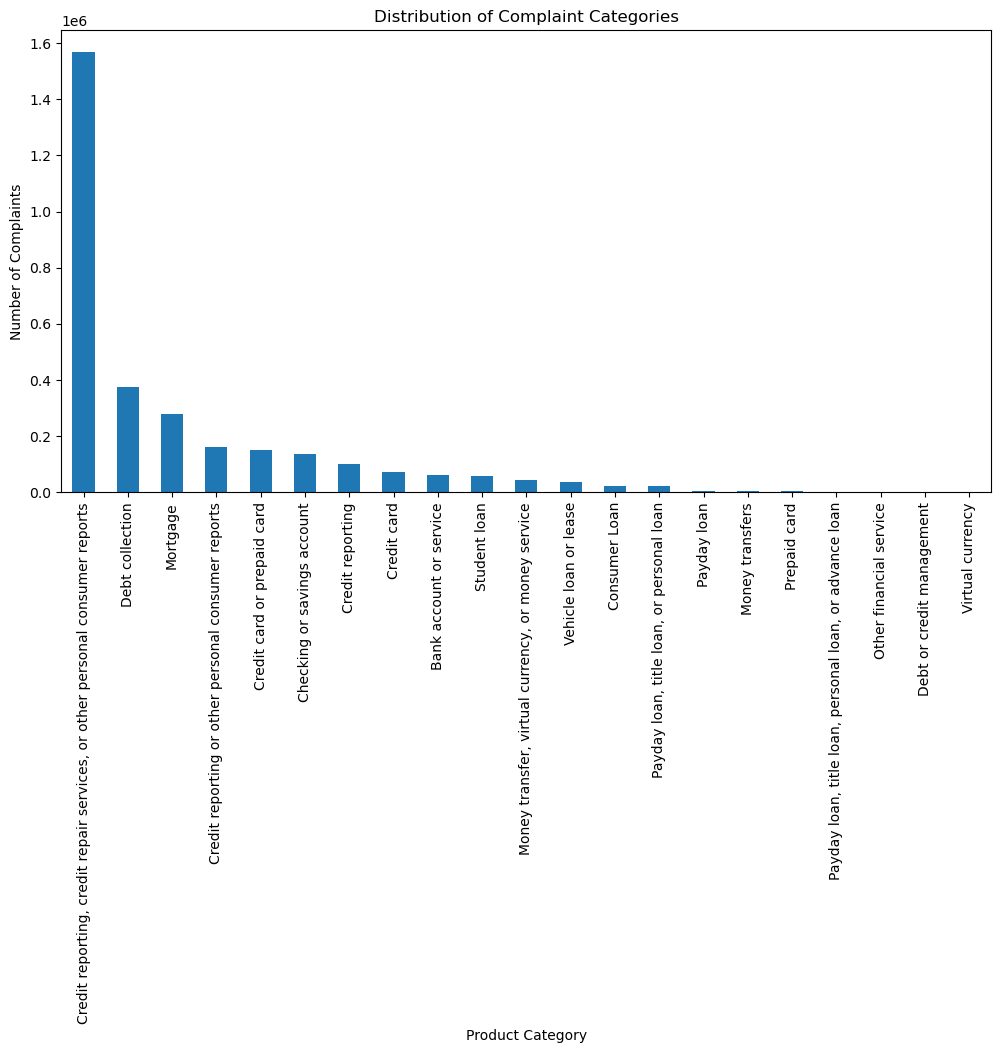

In [21]:
import matplotlib.pyplot as plt
# Creates a bar chart of how many complaints are in each Y category.

plt.figure(figsize=(12,6))
griv1['Y'].value_counts().plot(kind='bar') # counts occurrences per unique Y
plt.title("Distribution of Complaint Categories")
plt.xlabel("Product Category")
plt.ylabel("Number of Complaints")
plt.show()

In [22]:
griv1.isnull().sum()

Y    0
X    0
dtype: int64

In [23]:
# Replaces many textual product labels with integer labels (0..15). This converts the target to numeric classes suitable for classification.

griv1.Y.replace({
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Credit reporting or other personal consumer reports': 0,

    'Credit card or prepaid card': 1,
    'Prepaid card': 1,
    'Credit card': 1,

    'Debt collection': 2,

    'Mortgage': 3,
    'Checking or savings account': 4,
    'Money transfer, virtual currency, or money service': 5,

    'Payday loan, title loan, or personal loan': 6,
    'Payday loan, title loan, personal loan, or advance loan': 6,
    'Payday loan': 6,

    'Vehicle loan or lease': 7,
    'Bank account or service': 8,
    'Student loan': 9,
    'Money transfers': 10,
    'Credit reporting': 11,
    'Debt or credit management': 12,
    'Consumer Loan': 13,
    'Other financial service': 14,
    'Virtual currency': 15
}, inplace=True)


In [24]:
import nltk
from nltk.corpus import stopwords

In [25]:
# nltk.download('stopwords') will download the stopword list the first time you run this (internet required the first time).
# list_stopwords now contains English stopwords like 'the', 'and', 'is',... used to filter out very common words that carry little meaning.

nltk.download('stopwords')
list_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# string.punctuation is a string of punctuation characters (e.g. '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~'`).
# You access it, and later use it to remove punctuation in your text cleaning function

import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
# This is a simple preprocessing function (used as an analyzer in CountVectorizer):
# Loops over characters in mess and keeps only those not in punctuation → nonpunc list of chars.
# Joins chars back to a string with "".join(nonpunc).
# Splits on whitespace nonpunc.split() to produce tokens.
# Filters out tokens that are in list_stopwords.
# Returns a list of tokens (e.g. ['credit', 'report', 'late']).

def text_process(mess):
    """
    1. remove the punctuation
    2. remove the stopwords
    3. return the list of clean textwords
    
    """
    nonpunc = [char for char in mess if char not in string.punctuation] # list comprehension , remove punctuation
    nonpunc = "".join(nonpunc)

    return [ word for word in nonpunc.split() if word not in list_stopwords] # remove stopwords

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
# this is used to assign token and take a count of each unique word

In [29]:
# CountVectorizer builds a vocabulary from your corpus and returns document-term counts (bag-of-words).
# analyzer=text_process tells it to use your text_process function to turn raw text into a token list.
# .fit(griv1["X"]) learns the vocabulary (assigns integer index for each token across all documents).

bow_transformer = CountVectorizer(analyzer=text_process).fit(griv1["X"])

In [30]:
# Transforms each document into a sparse vector of token counts. TDM is usually a sparse matrix of shape

TDM = bow_transformer.transform(griv1.X) 

In [31]:
TDM.shape

(3100000, 340742)

In [32]:
from sklearn.model_selection import train_test_split
tdm_train , tdm_test, Y_train , Y_test = train_test_split ( TDM ,griv1.Y , test_size = .2)

In [33]:
labels = sorted(griv1['Y'].unique())

In [34]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight="balanced",solver='saga')
logreg.fit(tdm_train,Y_train)
from sklearn.metrics import confusion_matrix
pred = logreg.predict(tdm_test)
tab = confusion_matrix (Y_test ,pred,labels=labels)
print(tab)
print(tab.diagonal().sum() *100 / tab.sum())

[[294191   3153   1680    395    838    104    717   2539    202    449
      18  38074   2905     18    334      3]
 [  1906  27637    148    354   1861    388    793     78   1351     11
    1737    917   1608     41   6196    145]
 [   544    235  71042    237    186     46    315    249    125    101
     546    262    409    343    193      2]
 [   287     44     58  52152     38     41    656    169     73    332
     769    342    646     82     79      0]
 [   108    196     26     25  24795    366     85     20   1603      7
      15     66    118      3     30      6]
 [     9     74     16     18    142   5668     47      3     38      5
     908      1    328      5   1604      9]
 [   245     77     38     90     60     17   4150    102     38    137
      17    171    165     54     88      1]
 [   460     12     29     23     19      2    231   5590     11     14
       0    375     22    349      6      0]
 [     3    105      9     31    267     53     38      3  12050

In [35]:
from sklearn.metrics import classification_report
print(classification_report( Y_test ,pred))

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    345620
           1       0.84      0.61      0.71     45171
           2       0.97      0.95      0.96     74835
           3       0.98      0.94      0.96     55768
           4       0.88      0.90      0.89     27469
           5       0.84      0.64      0.73      8875
           6       0.53      0.76      0.62      5450
           7       0.62      0.78      0.69      7143
           8       0.77      0.95      0.85     12645
           9       0.90      0.86      0.88     11412
          10       0.11      0.61      0.19       825
          11       0.31      0.90      0.46     20158
          12       0.01      0.88      0.01        41
          13       0.77      0.91      0.83      4436
          14       0.01      0.87      0.03       148
          15       0.02      0.75      0.03         4

    accuracy                           0.85    620000
   macro avg       0.60   

In [36]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
nb = MultinomialNB()
nb.fit(tdm_train,Y_train)
pred_nb = nb.predict(tdm_test)
tab_nb = confusion_matrix(Y_test , pred_nb,labels=labels)
print(tab_nb)
print(tab_nb.diagonal().sum() *100 / tab_nb.sum())

[[325264   5677   2282   1153    320    269    108   1634      6    856
       0   8051      0      0      0      0]
 [  3639  38011    466    498   2102    208     25     71     39     52
       0     60      0      0      0      0]
 [   788    523  72548    355     97     33     66    218      0    199
       2      5      0      1      0      0]
 [   537    867     67  54156     43     13      7     21      1     20
       0     35      0      1      0      0]
 [   207    336     23     19  26700    166      3      7      1      4
       0      3      0      0      0      0]
 [    25    608     22     41    674   7469     13     13      1      8
       0      1      0      0      0      0]
 [   403    830    123    558    256     11   2717    215     39    277
       0     14      0      7      0      0]
 [   824     69     56     42     38      0      3   6064      0     17
       0     30      0      0      0      0]
 [    19    236     25     91   1242     58      3      6  10957

In [37]:
from sklearn.metrics import classification_report
print(classification_report( Y_test ,pred_nb))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96    345620
           1       0.80      0.84      0.82     45171
           2       0.95      0.97      0.96     74835
           3       0.95      0.97      0.96     55768
           4       0.85      0.97      0.90     27469
           5       0.85      0.84      0.84      8875
           6       0.87      0.50      0.63      5450
           7       0.66      0.85      0.74      7143
           8       0.99      0.87      0.92     12645
           9       0.87      0.92      0.90     11412
          10       0.93      0.03      0.06       825
          11       0.68      0.88      0.77     20158
          12       0.00      0.00      0.00        41
          13       0.92      0.69      0.79      4436
          14       1.00      0.19      0.32       148
          15       0.00      0.00      0.00         4

    accuracy                           0.93    620000
   macro avg       0.77   

In [38]:
import pickle
import os

os.makedirs("models", exist_ok=True)

with open("models/grievance_model.pkl", "wb") as f:
    pickle.dump((bow_transformer, nb), f)

In [ ]:
# streamlit run code for web app
# streamlit run griv.py